In [79]:
import os
import sys
import math
import tqdm
import wandb
import pylab
import torch
import logging

import numpy as np
import pandas as pd
import torch.nn as nn
import lightning.pytorch as pl

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chisquare, kstest
from torchmetrics import MeanAbsoluteError
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from lightning.pytorch.loggers import WandbLogger
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import Callback, LearningRateMonitor, ModelCheckpoint

# params
project_name = "MSU_interpol_unified_notebooks_structure_functions"

logger_path = '../wandb_local_logs'
data_path = '../../data/df_with_ABC.csv'

hyperparams_dict = {
    'scale_data': False,
    'augment': False,
    'add_weights': False,
    'augment_factor': 20,
    'test_size': 0.1,
    'batch_size': 256,
    'net_architecture': [5, 60, 80, 100, 120, 140, 240, 340, 440, 640, 2000, 1040, 640, 340, 240, 140, 100, 80, 60, 20, 3],
    'activation_function': nn.ReLU(),
    'loss_func': 'RMSELoss()',
    'optim_func': torch.optim.Adam,
    'max_epochs': 2000,
    'es_min_delta': 0.00001,
    'es_patience': 50,
    'lr': 0.001,
    'lr_factor': 0.5,
    'lr_patience': 5,
    'lr_cooldown': 20,
}


# set up loss
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()

    def forward(self, y_hat, y):
        criterion = torch.sqrt(torch.mean((y_hat - y)** 2))
        return criterion

global_losss_function = RMSELoss()

# set up loggers and wandb
wandb_logger = WandbLogger(project=project_name,
                           save_dir=logger_path)
exp_name = wandb_logger.experiment.name

logger_full_path = os.path.join(logger_path, project_name, exp_name)

os.makedirs(logger_full_path, exist_ok=True)
# logging.basicConfig(encoding='utf-8',
#                     level=logging.DEBUG,
#                     format='%(asctime)s : %(levelname)s : %(message)s',
#                     handlers=[logging.FileHandler(os.path.join(logger_full_path, 'logs.log'), mode='w'),
#                               logging.StreamHandler(sys.stdout)],
#                     force=True)


# define dataset and net
class InterpolDataSet(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.len = len(labels)

    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

    def __len__(self):
        return self.len


class InterpolDataModule(pl.LightningDataModule):
    def __init__(self, hyperparams):
        super().__init__()
        self.df = None
        self.hyperparams = hyperparams
        self.train_dataset = None
        self.val_dataset = None

    def augment(self, new_augm):
        augm = pd.Series({'Ebeam': np.random.normal(loc=new_augm.Ebeam, scale=new_augm.Ebeam / 30),
                          'W': np.random.normal(loc=new_augm.W, scale=new_augm.W / 30),
                          'Q2': np.random.normal(loc=new_augm.Q2, scale=new_augm.Q2 / 30),
                          'cos_theta': np.clip(
                              np.random.normal(loc=new_augm.cos_theta, scale=abs(new_augm.cos_theta / 30)), -1, 1),
                          'phi': np.clip(np.random.normal(loc=new_augm.phi, scale=new_augm.phi / 30), 0, 2 * np.pi),
                          'A': np.random.normal(loc=new_augm.A, scale=new_augm.A_error / 3),
                          'B': np.random.normal(loc=new_augm.B, scale=new_augm.B_error / 3),
                          'C': np.random.normal(loc=new_augm.C, scale=new_augm.C_error / 3)
                          })
        return augm

    def setup(self, stage):
        # data reading and preprocessing
        df = pd.read_csv(data_path)
        df = df.dropna()

        feature_columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']

        feature_data = df[feature_columns]
        label_data = df[['A', 'B', 'C']]

        if self.hyperparams.get('augment'):
            aug_series_list = []
            for i in tqdm.tqdm(df.itertuples()):
                for _ in range(self.hyperparams.get('augment_factor')):
                    aug_series_list.append(self.augment(i))

            aug_df = pd.DataFrame(aug_series_list)
            df = pd.concat([df, aug_df])
        else:
            pass

        self.df = df

        train_feature_data, val_feature_data, train_label_data, val_label_data = train_test_split(feature_data,
                                                                                                  label_data,
                                                                                                  test_size=self.hyperparams.get(
                                                                                                      'test_size'),
                                                                                                  random_state=1438)

        self.train_dataset = InterpolDataSet(
            torch.tensor(train_feature_data[feature_columns].values, dtype=torch.float32),
            torch.tensor(train_label_data.values, dtype=torch.float32))

        self.val_dataset = InterpolDataSet(torch.tensor(val_feature_data[feature_columns].values, dtype=torch.float32),
                                           torch.tensor(val_label_data.values, dtype=torch.float32))

    def train_dataloader(self):
        return DataLoader(dataset=self.train_dataset, batch_size=self.hyperparams.get('batch_size'), shuffle=False,
                          num_workers=0)

    def val_dataloader(self):
        return DataLoader(dataset=self.val_dataset, batch_size=self.hyperparams.get('batch_size'), shuffle=False,
                          num_workers=0)


class PrintCallbacks(Callback):
    def on_train_start(self, trainer, pl_module):
        logging.info("Training is starting")

    def on_train_end(self, trainer, pl_module):
        logging.info("Training is ending")

    def on_train_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.training_step_outputs).mean()
        logging.info(f"epoch: {pl_module.current_epoch}; train_loss: {epoch_mean}")
        pl_module.training_step_outputs.clear()

    def on_validation_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.validation_step_outputs).mean()
        logging.info(f"epoch: {pl_module.current_epoch}; val_loss: {epoch_mean}")
        pl_module.validation_step_outputs.clear()


class InterpolRegressor(pl.LightningModule):
    def __init__(self, hyperparams):
        super(InterpolRegressor, self).__init__()

        self.train_loss, self.train_mae, self.val_loss, self.val_mae = 0, 0, 0, 0
        self.hyperparams = hyperparams
        self.save_hyperparameters(self.hyperparams)

        self.mae = MeanAbsoluteError()
        self.loss_func = global_losss_function

        self.optim = self.hyperparams.get('optim_func')

        self.net_architecture = self.hyperparams.get('net_architecture')
        self.activation_function = self.hyperparams.get('activation_function')

        self.training_step_outputs = []
        self.validation_step_outputs = []

        self.net = nn.Sequential()
        for i in range(1, len(self.net_architecture)):
            self.net.append(nn.Linear(self.net_architecture[i - 1], self.net_architecture[i]))
            if i != len(self.net_architecture) - 1:
                self.net.append(self.activation_function)
            else:
                pass

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = self.loss_func
        self.train_loss = loss.forward(y_hat=y_hat.reshape(-1), y=y.reshape(-1))
        self.train_mae = self.mae(y_hat.reshape(-1), y.reshape(-1))

        self.log('train_loss', self.train_loss, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_mae', self.train_mae, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

        self.training_step_outputs.append(self.train_loss)
        return self.train_loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = self.loss_func
        self.val_loss = loss.forward(y_hat=y_hat.reshape(-1), y=y.reshape(-1))
        self.val_mae = self.mae(y_hat.reshape(-1), y.reshape(-1))

        self.log('val_loss', self.val_loss, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_mae', self.val_mae, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

        self.validation_step_outputs.append(self.val_loss)
        return self.val_loss

    def on_validation_epoch_end(self):
        sch = self.lr_schedulers()
        if isinstance(sch, torch.optim.lr_scheduler.ReduceLROnPlateau) and self.trainer.current_epoch != 0:
            sch.step(self.trainer.callback_metrics["val_loss"])

    def configure_callbacks(self):
        early_stop_callback = EarlyStopping(monitor="val_loss", mode="min",
                                            min_delta=self.hyperparams.get('es_min_delta'),
                                            patience=self.hyperparams.get('es_patience'),
                                            verbose=True)

        checkpoint_callback = ModelCheckpoint(save_top_k=3,
                                              monitor="val_loss",
                                              mode="min",
                                              dirpath=f"{logger_full_path}/checkpoints",
                                              filename="{exp_name}{val_loss:.5f}-{epoch:02d}")

        lr_monitor = LearningRateMonitor(logging_interval='epoch')

        print_callback = PrintCallbacks()

        return [early_stop_callback, checkpoint_callback, print_callback, lr_monitor]

    def configure_optimizers(self):
        optimizer = self.optim(self.parameters(), lr=self.hyperparams.get('lr'))
        lr_optim = ReduceLROnPlateau(optimizer=optimizer,
                                     mode='min',
                                     factor=self.hyperparams.get('lr_factor'),
                                     patience=self.hyperparams.get('lr_patience'),
                                     cooldown=self.hyperparams.get('lr_cooldown'),
                                     threshold=0.01,
                                     verbose=True)
        return {"optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": lr_optim,
                    "interval": "epoch",
                    "monitor": "val_loss",
                    "frequency": 2,
                    "name": 'lr_scheduler_monitoring'}
                }


data = InterpolDataModule(hyperparams_dict)
data.setup('test')
df = data.df
df_all = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']]
df_target = df[['A', 'B', 'C']]

model = InterpolRegressor.load_from_checkpoint(f'/Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_unified_notebooks_structure_functions/comfy-morning-6/checkpoints/exp_name=0val_loss=0.24611-epoch=1526.ckpt', hyperparams=hyperparams_dict)


model.eval()
type(model)

/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.11/lib/python3.11/site-packages/lightning/pytorch/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


KeyboardInterrupt: 

In [42]:
def cross_sections_check(df, E_beam, W, Q2, cos_theta):
    df_example_set = df[(df.Ebeam == E_beam)&
                        (df.W == W)&
                        (df.Q2 == Q2)&
                        (np.round(df.cos_theta, 1) == cos_theta)].sort_values('phi')
    if len(df_example_set)==0:
        print(len(df_example_set), E_beam, W, Q2, cos_theta)
        return None

    df_example_set_for_prediction = pd.DataFrame({'Ebeam' : [E_beam for _ in np.arange(0, 2*np.pi, 0.01)],
                                                  'W' : [W for _ in np.arange(0, 2*np.pi, 0.01)],
                                                  'Q2' : [Q2 for _ in np.arange(0, 2*np.pi, 0.01)],
                                                  'cos_theta' : [cos_theta for _ in np.arange(0, 2*np.pi, 0.01)],
                                                  'phi' : [phi for phi in np.arange(0, 2*np.pi, 0.01)]})

#     return df_example_set
    with torch.no_grad():
        preds = model.forward(torch.tensor(df_example_set_for_prediction.to_numpy(),dtype=torch.float32)).detach()
        df_example_set_for_prediction['A'] = preds[:, 0]
        df_example_set_for_prediction['B'] = preds[:, 1]
        df_example_set_for_prediction['C'] = preds[:, 2]

        df_example_set_for_prediction['dsigma_dOmega_predicted'] = df_example_set_for_prediction['A'] + \
                                                                   df_example_set_for_prediction['B']*np.cos(2*df_example_set_for_prediction['phi']) + \
                                                                   df_example_set_for_prediction['C']*np.cos(df_example_set_for_prediction['phi'])

    def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

    #input data
    xdata = df_example_set.phi
    ydata = df_example_set.dsigma_dOmega
    ydata_error = df_example_set.error

    #fitting the data
    popt, pcov = curve_fit(func_cos, xdata, ydata, sigma=ydata_error, absolute_sigma=True)

    a, b, c = popt[0], popt[1], popt[2]
    #print the fitted parameters
    print("a = %s , b = %s, c = %s" % (a, b, c))
    phi_theory = [i for i in np.arange(0, 2*np.pi, 0.01)]
    dsigma_dOmega_theory = [func_cos(x, a, b, c) for x in phi_theory]

    df_theory = pd.DataFrame({'phi_theory': phi_theory,
                              'dsigma_dOmega_theory': dsigma_dOmega_theory})

    df_chi_2 = pd.merge_asof(df_example_set, df_theory, left_on='phi', right_on='phi_theory')
    df_chi_2 = pd.merge_asof(df_chi_2, df_example_set_for_prediction, on='phi')
    df_chi_2 = df_chi_2[['phi', 'dsigma_dOmega', 'dsigma_dOmega_theory', 'dsigma_dOmega_predicted']]

    real = df_chi_2['dsigma_dOmega'].apply(lambda x: np.round(x, 6)).values
    theory = df_chi_2['dsigma_dOmega_theory'].apply(lambda x: np.round(x, 6)).values
    preds = df_chi_2['dsigma_dOmega_predicted'].apply(lambda x: np.round(x, 6)).values

    stat_theory_chi, p_value_theory_chi = np.round(chisquare(real, np.sum(real)/np.sum(theory)*theory), 3)
    stat_preds_chi, p_value_preds_chi = np.round(chisquare(real, np.sum(real)/np.sum(preds)*preds), 3)

    stat_theory_ks, p_value_theory_ks = np.round(kstest(real, theory), 2)
    stat_preds_ks, p_value_preds_ks = np.round(kstest(real, preds), 2)

    plt.figure(figsize=(22, 6), dpi=80)
    plt.plot(phi_theory,
             dsigma_dOmega_theory,
             label=f'fitted, chi^2 = {stat_theory_chi}, p_value = {p_value_theory_chi}, ks = {stat_theory_ks}, p_value = {p_value_theory_ks}')
    plt.plot(df_example_set_for_prediction.phi,
             df_example_set_for_prediction.dsigma_dOmega_predicted,
             color='green',
             label=f'predicted; chi^2 = {stat_preds_chi}, p_value = {p_value_preds_chi}, ks = {stat_preds_ks}, p_value = {p_value_preds_ks}')
    plt.scatter(x=df_example_set.phi,
                y=df_example_set.dsigma_dOmega,
                color='red', marker='*', label=f"real_data with params Ebeam: {E_beam}, W: {W}, Q2: {Q2}, cos_theta: {cos_theta}")
    plt.errorbar(x=df_example_set.phi,
                 y=df_example_set.dsigma_dOmega,
                 yerr=df_example_set.error,
                 color='red',
                 fmt='o')

    plt.xlabel("phi: rad", fontsize="20")
    plt.ylabel("dsigma_dOmega: barn", fontsize="20")

    plt.legend(loc ="upper right", fontsize="15")
    plt.savefig(f'./checks_unified_sf/cross_sections/E_beam={E_beam}/Q2={Q2}/W={W}/E_beam={E_beam}_Q2={Q2}_W={W}_cos_theta={cos_theta}.png')
    plt.close()
    return True


In [49]:
E_beam = 1.515

for Q2 in tqdm.tqdm(np.sort(df[df.Ebeam == E_beam].Q2.unique())):
    os.makedirs(f"./checks_unified_sf/cross_sections/E_beam={E_beam}/Q2={Q2}")
    for W in tqdm.tqdm([1.23, 1.53, 1.715, 1.95]):
        os.makedirs(f"./checks_unified_sf/cross_sections/E_beam={E_beam}/Q2={Q2}/W={W}")
        for cos_theta in [-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
            try:
                cross_sections_check(df, E_beam, W, Q2, cos_theta)
            except Exception as e:
                print(e)
                print(E_beam, W, Q2, cos_theta)

# Structure functions

In [ ]:
preds = model.forward(torch.tensor(df_all.to_numpy(),dtype=torch.float32)).detach()

# df_grid
Ebeam = 5.754
step_W = 0.005
step_Q2 = 0.1
step_cos_theta = 0.1
step_phi = 0.05


data_grid = []
for W in tqdm.tqdm(np.arange(1.1, 2.2 + step_W, step_W)):
    for Q2 in np.arange(1.6, 4.3 + step_Q2, step_Q2):
         for cos_theta in np.arange(-1, 1+step_cos_theta, step_cos_theta):
                for phi in np.arange(0, 2*np.pi, step_phi):
                    data_grid.append([Ebeam,
                                      W,
                                      Q2,
                                      cos_theta,
                                      phi])

df_grid = pd.DataFrame(data_grid)
df_grid.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']


df_grid.W = np.round(df_grid.W, 3)
df_grid.Q2 = np.round(df_grid.Q2, 3)
df_grid.cos_theta = np.round(df_grid.cos_theta, 3)
df_grid.phi = np.round(df_grid.phi, 3)

df_grid_parts = np.array_split(df_grid, 100)
df_grid_parts_preds = []
for df_grid_part in tqdm.tqdm(df_grid_parts):
    preds = model.forward(torch.tensor(df_grid_part.to_numpy(),dtype=torch.float32)).detach()

    df_grid_part['A'] = preds[:, 0]
    df_grid_part['B'] = preds[:, 1]
    df_grid_part['C'] = preds[:, 2]

    df_grid_parts_preds.append(df_grid_part)

df_grid = pd.concat(df_grid_parts_preds)

df_grid['cross_sections_preds'] = df_grid['A'] + df_grid['B']*np.cos(2*df_grid['phi']) + df_grid['C']*np.cos(df_grid['phi'])

In [52]:
df_a = pd.read_csv('../../data/final_table.csv', header=None, sep='\t',
                    names=['Channel', 'MID', 'Wmin', 'Wmax', 'Q2min', 'Q2max', 'Cos(theta)', 'sigma_t', 'd_sigma_t',
                    'sigma_l', 'd_sigma_l', 'sigma_tt', 'd_sigma_tt', 'sigma_lt', 'd_sigma_lt', 'eps'])
df_a = df_a[df_a.Channel.isin([8, 14, 41, 141])]
df_a['W'] = (df_a['Wmax'] + df_a['Wmin'])/2
df_a['Q2'] = (df_a['Q2max'] + df_a['Q2min'])/2
df_a['cos_theta'] = df_a['Cos(theta)']

In [67]:
def gen_ABC_W(Ebeam, Q2, cos_theta):

    df_tmp = df_grid[(df_grid.Ebeam == Ebeam)&
                    (df_grid.Q2 == Q2)&
                    (df_grid.cos_theta == cos_theta)].drop(['phi'], axis=1).drop_duplicates()

    return df_tmp

def real_almaz_ABC_W(Q2, cos_theta):
    df_tmp = df_a[(df_a.Q2 == Q2)&(df_a.cos_theta == cos_theta)]
    return df_tmp

def plot_gen_real_almaz(params_gen, params_real):
    params = {'legend.fontsize': 'x-large',
              'figure.figsize': (25, 5),
             'axes.labelsize': 'x-large',
             'axes.titlesize':'x-large',
             'xtick.labelsize':'x-large',
             'ytick.labelsize':'x-large'}
    pylab.rcParams.update(params)

    df_ABC_W_gen = gen_ABC_W(**params_gen)
    df_ABC_W_real = real_almaz_ABC_W(**params_real)


    plt.figure(figsize=(28, 12), dpi=80)

    plt.scatter(df_ABC_W_gen.W, df_ABC_W_gen.A, label= 'AI gen', color='red', s=20, marker='v')

    plt.scatter(df_ABC_W_real.W, df_ABC_W_real.sigma_t + df_ABC_W_real.sigma_l, label= 'real')
    plt.errorbar(df_ABC_W_real.W, df_ABC_W_real.sigma_t + df_ABC_W_real.sigma_l, yerr=df_ABC_W_real.d_sigma_t + df_ABC_W_real.d_sigma_l, fmt='o')


    plt.tick_params(axis='both', which='minor', labelsize=20)
    plt.xlabel("W", fontsize=20)
    plt.ylabel("A", fontsize=20)
    plt.title(f'Plot of structure functions. Params gen: {params_gen}. Params real: {params_real}', fontsize=20)
    plt.legend(fontsize=20)
    plt.show()

    os.makedirs(f"./checks_unified_sf/structure_functions/E_beam={params_gen.get('Ebeam')}/Q2={params_gen.get('Q2')}")
    plt.savefig(f"./checks_unified_sf/structure_functions/E_beam={params_gen.get('Ebeam')}/Q2={params_gen.get('Q2')}/E_beam={params_gen.get('Ebeam')}_Q2={params_gen.get('Q2')}_cos_theta={params_gen.get('cos_theta')}.png")
    plt.close()

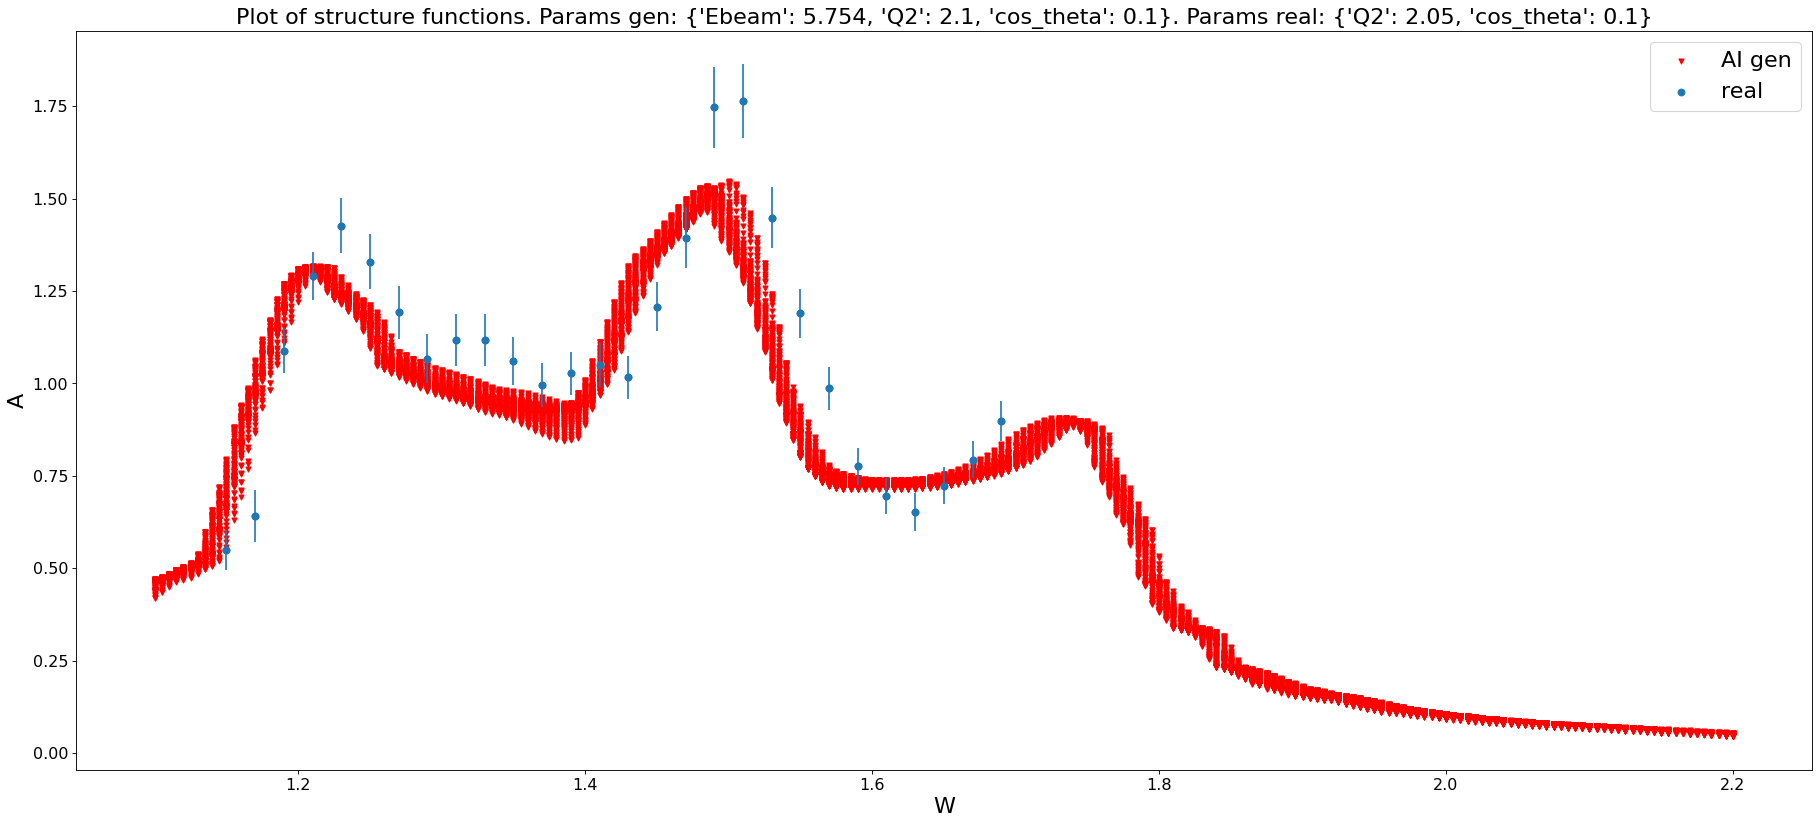

FileExistsError: [Errno 17] File exists: './checks_unified_sf/structure_functions/E_beam=5.754/Q2=2.1'

In [90]:
plot_gen_real_almaz({'Ebeam' : 5.754, 'Q2' : 2.1, 'cos_theta' : 0.1}, {'Q2' : 2.05, 'cos_theta' : 0.1})

In [86]:
df_grid[(df_grid.Ebeam==5.754)&
        (df_grid.Q2==2.2)&
        (df_grid.cos_theta==-0.1)]